In [36]:
from SampleExtraction.RaceCardsSplitter import RaceCardsSplitter
from SampleExtraction.SampleEncoder import SampleEncoder
from Persistence.RaceCardPersistence import RaceCardsPersistence
from SampleExtraction.FeatureManager import FeatureManager
from DataAbstraction.Present.Horse import Horse
import pickle

BET_MODEL_PATH: str = "../data/bet_model_non_shuffled.dat"

with open(BET_MODEL_PATH, "rb") as f:
    bet_model = pickle.load(f)


persistence = RaceCardsPersistence("train_race_cards")
race_cards = persistence.load_every_month_non_writable()

feature_manager = FeatureManager(features=bet_model.features)
feature_manager.set_features(list(race_cards.values()))

race_cards_splitter = RaceCardsSplitter()
train_race_cards, validation_race_cards = race_cards_splitter.split_race_cards(race_cards)

#Validation:
sample_encoder = SampleEncoder(feature_manager.features)
train_samples = sample_encoder.transform(list(train_race_cards.values()))

feature_names = [feature.get_name() for feature in feature_manager.features]
train_samples = train_samples[feature_names + [Horse.RELEVANCE_KEY]]

#Validation:
validation_samples = sample_encoder.transform(list(validation_race_cards.values()))

feature_names = [feature.get_name() for feature in feature_manager.features]
validation_samples = validation_samples[feature_names + [Horse.RELEVANCE_KEY]]

validation_samples

,Current_Odds_Feature,Speed_Figure_1,Speed_Figure_2,Speed_Figure_3,Speed_Figure_4,Speed_Figure_5,Speed_Figure_6,Speed_Figure_7,Speed_Figure_8,Speed_Figure_9,...,Is_Colt,Average_Earnings_Jockey_0,Average_Earnings_Jockey_1,Average_Earnings_Trainer_2,Win_Rate_Jockey_0,Win_Rate_Trainer_1,Average_Place_Similar_Distance_1000,Place_2_Races_Ago,Place_3_Races_Ago,relevance
0,2.25,NaN,99.727938,48.267038,NaN,NaN,NaN,NaN,NaN,NaN,...,0,3946.818182,36082.162162,2423.600000,0.090909,0.191837,2.000000,1.0,3.0,3
1,15.00,NaN,89.436938,NaN,58.992101,47.041472,95.059058,99.624509,107.145544,75.621005,...,0,3155.333333,1556.363636,16378.750000,0.222222,0.115385,3.125000,3.0,NaN,0
2,8.50,31.429789,72.033038,81.714287,80.244185,73.765224,112.907614,-19.538852,87.855957,16.084425,...,0,0.000000,1500.593909,1806.000000,0.000000,0.250000,3.551724,2.0,1.0,2
3,7.50,32.123019,85.246076,100.868116,93.388853,NaN,77.287268,38.142478,91.056381,78.532083,...,0,11522.625000,1455.261663,1258.351171,0.125000,0.104294,4.812500,1.0,2.0,1
4,8.00,102.439332,NaN,36.267742,71.872744,92.438519,NaN,NaN,78.104985,45.554194,...,0,15485.000000,1364.937500,1457.941606,1.000000,0.124224,3.571429,NaN,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29943,3.25,66.671711,52.347409,82.668044,68.440769,NaN,NaN,NaN,NaN,NaN,...,0,1892.328358,1927.148438,1694.743961,0.097015,0.097826,5.250000,10.0,4.0,2
29944,8.00,82.434417,66.402841,57.478198,78.714014,78.197825,95.755973,68.186664,88.388827,68.535930,...,0,828.083969,1904.233333,384.909091,0.083969,0.000000,4.032258,7.0,6.0,0
29945,7.00,78.894253,68.853227,-2.694500,71.112976,81.454537,49.603825,58.680103,65.189712,43.649942,...,0,1429.866197,1023.714286,858.270833,0.049296,0.048128,6.285714,3.0,10.0,0
29946,6.00,114.925681,58.426804,46.711973,29.521087,51.390747,83.976382,48.559225,89.171057,121.551716,...,0,1657.641026,1760.448718,813.492625,0.197802,0.090000,6.615385,10.0,13.0,1


In [46]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import pandas as pd

print(len(train_samples))
print(len(validation_samples))
train_samples["label"] = 0
validation_samples["label"] = 1


shift_dataset = pd.concat([train_samples[:25000], validation_samples[:25000]], ignore_index=True, sort=False)
shift_dataset = shift_dataset.fillna(value=-1)
#shift_dataset = shift_dataset.drop(
#    ["Age", "Purse", "Draw_Bias", "Draw_Bias_1", "Draw_Bias_2", "Draw_Bias_3", "Draw_Bias_4", "Draw_Bias_5", "Draw_Bias_6", "Draw_Bias_7", "Draw_Bias_8", "Draw_Bias_9", "Draw_Bias_10", "Is_Colt", "Track", "Average_Earnings_Jockey_0"], axis=1
#)
#speed_figures = [f"Speed_Figure_{i}" for i in range(1, 11)]
past_odds = [f"Past_Odds_{i}" for i in range(1, 11)]
past_class = [f"Past_Class_{i}" for i in range(1, 11)]
#past_place = [f"Place_2_Races_Ago", "Place_3_Races_Ago"]
#past_ratings = [f"Rating_{i}" for i in range(1, 11)]
#draw_bias = [f"Draw_Bias_{i}" for i in range(1, 11)]
shift_dataset = shift_dataset[["Current_Odds_Feature", "Track", "Deviation_Speed_Figure", "Purse", "Past_Race_Count", "label"] + past_odds + past_class + [Horse.RELEVANCE_KEY]]

shift_X = shift_dataset.loc[:, shift_dataset.columns != "label"]
scaler = StandardScaler().fit(shift_X)
shift_X = scaler.transform(shift_X)

shift_y = shift_dataset.loc[:, "label"]

X_train, X_test, y_train, y_test = train_test_split(shift_X, shift_y, test_size=0.33, random_state=42, stratify=shift_y)

log_regression_classifier = LogisticRegression(random_state=0).fit(X_train, y_train)
print(log_regression_classifier.score(X_test, y_test))

coef_data = {
    "feature name": list([column for column in shift_dataset.columns if column != "label"]),
    "coeff": list(list(log_regression_classifier.coef_)[0]),
}
coeff_df = pd.DataFrame.from_dict(coef_data)
coeff_df.sort_values(by=["coeff"])

131702
29948
0.5431515151515152


,feature name,coeff
0,Current_Odds_Feature,-0.060161
3,Purse,-0.052098
18,Past_Class_4,-0.050268
16,Past_Class_2,-0.043796
4,Past_Race_Count,-0.041219
15,Past_Class_1,-0.029682
17,Past_Class_3,-0.024756
24,Past_Class_10,-0.006120
20,Past_Class_6,-0.000200
2,Deviation_Speed_Figure,0.000476


/home/daniel/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/daniel/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


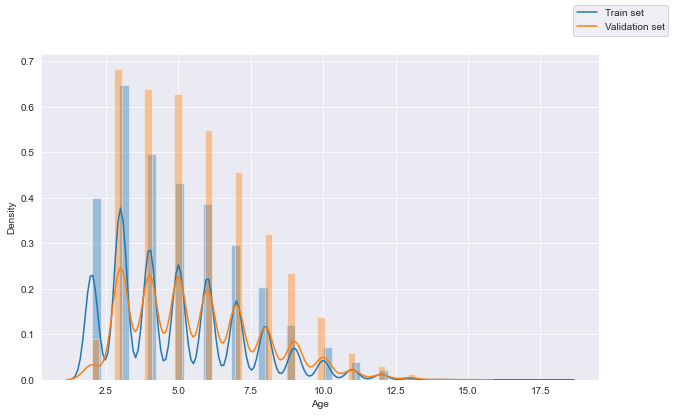

In [13]:
from matplotlib import pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(10,6))
sns.distplot(train_samples["Age"])
sns.distplot(validation_samples["Age"])

fig.legend(labels=["Train set", "Validation set"])